# SIT744 Practical 6: Introducing ConvNet

*Dr Wei Luo*

<div class="alert alert-info">
We suggest that you run this notebook using Google Colab.
</div>

## Learning objectives

- Construct and train a Convolutional Neural Network
- Regularise training with data augmentation and dropout

## Pre-practical readings

- [Introduction to convnets](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.1-introduction-to-convnets.ipynb)
- [Using convnets with small datasets](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.2-using-convnets-with-small-datasets.ipynb)

## Task 1 Training a convnet

We will use the cats vs. dogs dataset in the textbook to show how to build a ConvNet to classify cat vs dog photos.

### Task 1.1 Prepare dataset

 As the dataset is available in `tfds`, we will get it from there.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

TRAIN_DS_SIZE = 2000
VALID_DS_SIZE = 1000
TEST_DS_SIZE = 1000

(cat_dog_train, cat_dog_valid, cat_dog_test), info = tfds.load('cats_vs_dogs',
                                                               split=[f'train[:{TRAIN_DS_SIZE}]',
                                                                      f'train[{TRAIN_DS_SIZE}:{TRAIN_DS_SIZE + VALID_DS_SIZE}]',
                                                                      f'train[{TRAIN_DS_SIZE + VALID_DS_SIZE}:{TRAIN_DS_SIZE + VALID_DS_SIZE + TEST_DS_SIZE}]'],
                                                               with_info=True,
                                                               as_supervised=True)


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete8NP5NG/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

You can display some images using the function from the last practical.

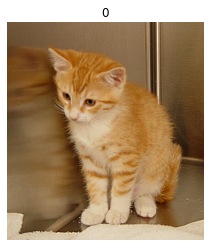

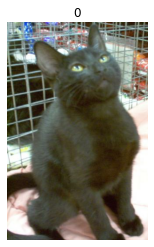

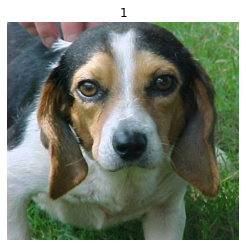

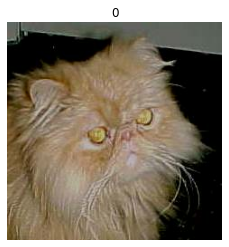

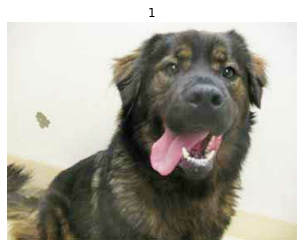

In [ ]:
## Show the image and label
import matplotlib.pyplot as plt
import numpy as np

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

for image, label in cat_dog_valid.take(5):
  show(image, label.numpy())

**exercise**

1. Are the images of equal size? What is the value range of each pixel?
2. What happens if you change the argument `as_supervised` of load() to `False`?
3. Check if the two classes are balanced in the data splits.

Last week, we saw how to use `map` function to preprocess images.

In [ ]:
IMAGE_SIZE = 150
def pre_process_image(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) ## Instead of manually scale the image, call a `tf.image` tool
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) # height and width
  return image, label

TRAIN_BATCH_SIZE = 20
train_batches = cat_dog_train.map(pre_process_image).batch(TRAIN_BATCH_SIZE).cache().repeat()
validation_batches = cat_dog_valid.map(pre_process_image).batch(TRAIN_BATCH_SIZE).cache().repeat()

**question** Why do we add `repeat()` at the end of the pipelines?


### Task 1.2 Build a convnet

We follow the common practice of using multiple blocks of Conv2D+MaxPooling2D layers. The number of channels was increased from 32 to 128, to form the visual features.
In the end, two dense layers were used to perform the classification based on the convolutional features.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers



def make_model():

  model = models.Sequential()

  ## Convolutional base
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  ## Dense head
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))  # for classification
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

  return model

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

Now we can feed the input pipelines to the model's `fit` method.
As we used `repeat()` in the pipelines, we need to define what an **epoch** means. This is done through the `steps_per_epoch` argument.

In [ ]:
%%time

model = make_model()

history = model.fit(
      train_batches,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_batches,
      validation_steps=50
      )

model.save('cats_and_dogs_small_1.h5')

Epoch 1/30
100/100 [==============================] - 6s 58ms/step - loss: 0.6911 - acc: 0.5370 - val_loss: 0.6871 - val_acc: 0.5130
Epoch 2/30
100/100 [==============================] - 3s 34ms/step - loss: 0.6672 - acc: 0.5925 - val_loss: 0.6448 - val_acc: 0.6500
Epoch 3/30
100/100 [==============================] - 3s 34ms/step - loss: 0.6269 - acc: 0.6460 - val_loss: 0.6138 - val_acc: 0.6740
Epoch 4/30
100/100 [==============================] - 3s 34ms/step - loss: 0.5911 - acc: 0.6905 - val_loss: 0.5936 - val_acc: 0.6890
Epoch 5/30
100/100 [==============================] - 3s 35ms/step - loss: 0.5591 - acc: 0.7170 - val_loss: 0.5758 - val_acc: 0.7010
Epoch 6/30
100/100 [==============================] - 4s 35ms/step - loss: 0.5309 - acc: 0.7390 - val_loss: 0.5673 - val_acc: 0.7160
Epoch 7/30
100/100 [==============================] - 3s 35ms/step - loss: 0.5045 - acc: 0.7555 - val_loss: 0.5596 - val_acc: 0.7240
Epoch 8/30
100/100 [==============================] - 4s 35ms/step - 

We will use a nicer-looking plot function to view the training curves.

In [ ]:
%pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ettexxuq
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ettexxuq
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=82437 sha256=7061816317bcc162e8583614592fac5e205e09688cded48ed489f65828303769
  Stored in directory: /tmp/pip-ephem-wheel-cache-h99oe4of/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


(0.0, 1.0)

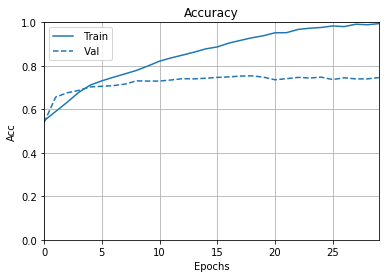

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"": history}, metric = "acc")
plt.title("Accuracy")
plt.ylim([0,1])

Overfitting is more obvious from the plot of loss functions.

(0.0, 1.0)

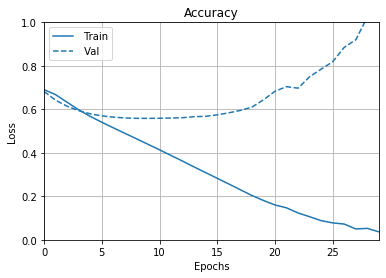

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"": history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])

Let's look at how the model performs on the test set.

In [ ]:
model.evaluate(cat_dog_test.map(pre_process_image).batch(TRAIN_BATCH_SIZE))

50/50 [==============================] - 2s 42ms/step - loss: 0.9294 - acc: 0.7610


[0.9294068217277527, 0.7609999775886536]

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


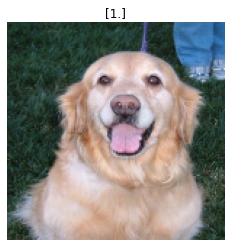

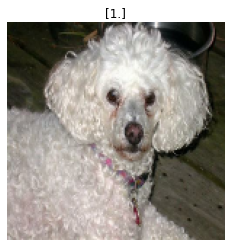

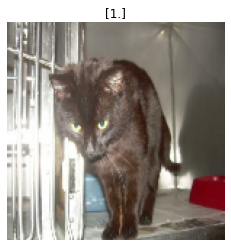

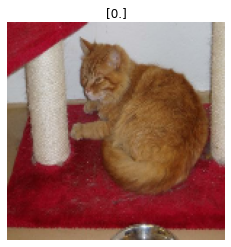

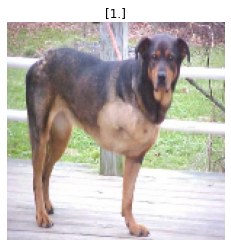

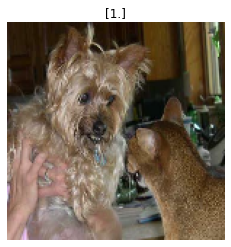

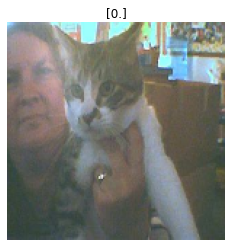

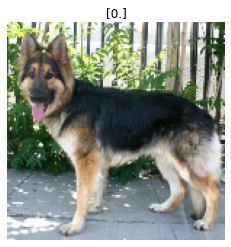

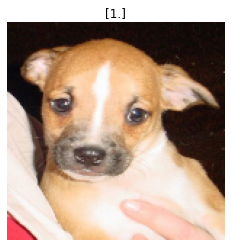

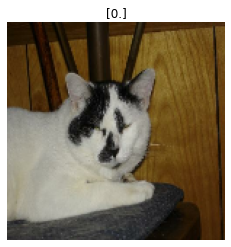

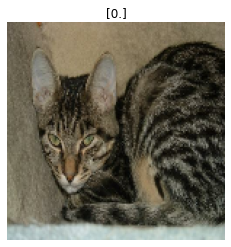

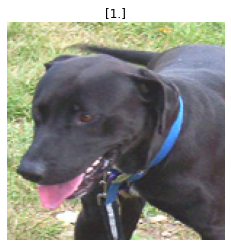

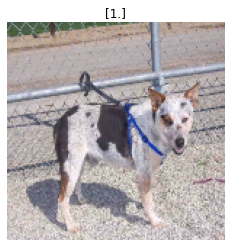

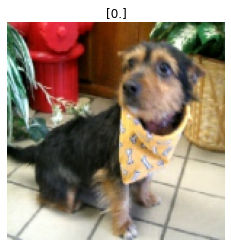

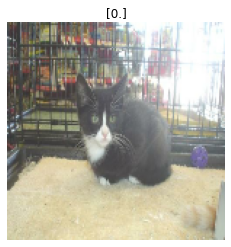

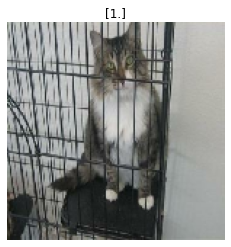

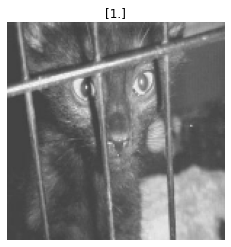

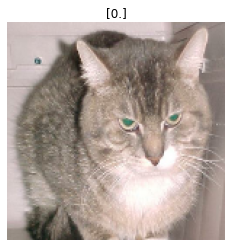

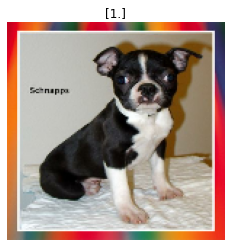

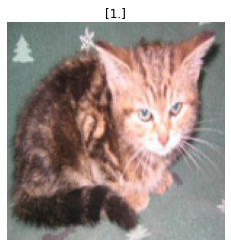

In [ ]:
for images, labels in cat_dog_test.map(pre_process_image).batch(TRAIN_BATCH_SIZE).take(1):
  predictions = model.predict(images)
  for image, prediction in zip(images, predictions):
    show(image, np.round(prediction))

**exercise** We used 3x3 convolution filters in the above example. Try increase the size of the convolution filters (particular at the first convolution layer) and see how the training and testing accuracy change. You may change the `strides` argument for larger filters.

## Task 2 Regularise the training


### Task 2.1 Using data augmentation

In Week 5, we learned that two ways to address overfitting include data augmentation and regularisation. In training convnet, data augmentation often means generating randomly transformed images from the existing training set. We can use image transformations provided in `tf.image`.

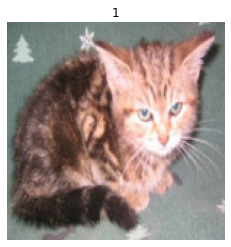

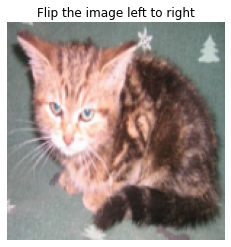

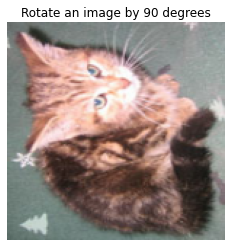

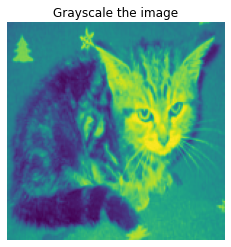

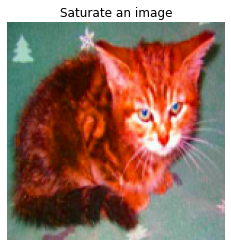

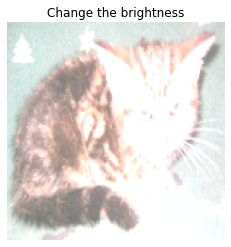

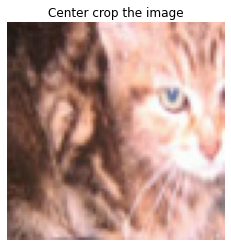

In [ ]:
for images, labels in cat_dog_train.take(1):
  show(image, label.numpy())

  show(tf.image.flip_left_right(image), label="Flip the image left to right")

  show(tf.image.rot90(image), "Rotate an image by 90 degrees")

  show(tf.squeeze(tf.image.rgb_to_grayscale(image)), "Grayscale the image")

  show(tf.image.adjust_saturation(image, 3), "Saturate an image")

  show(tf.image.adjust_brightness(image, 0.4), "Change the brightness")

  show(tf.image.central_crop(image, central_fraction=0.5), "Center crop the image")


**exercise** Follow the example above to

- flip the image upside down
- change the image with random brightness
- change the image with random contrast
- randomly crop the image


Now let's add random transformations to the input pipeline.

In [ ]:
for images, labels in cat_dog_train.take(1):
  show(image, label.numpy())

  show(tf.image.flip_up_down(image), label="Flip the image upside down")

  show(tf.image.random_brightness(image, max_delta=0.1), "Randomly change the image brightness")

  show(tf.image.random_contrast(image, lower=0.8, upper=1.2), "Randomly change the image contrast")

  show(tf.image.random_crop(image, size=[CROP_SIZE, CROP_SIZE, 3]), "Randomly crop the image")

  show(tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE]), "Resize image to the original size")



In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def augment(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = tf.image.resize_with_pad(image, IMAGE_SIZE + 6, IMAGE_SIZE + 6) # Add pixels of padding
  image = tf.image.random_crop(image, size=[IMAGE_SIZE, IMAGE_SIZE, 3]) # Random crop back to IMAGE_SIZExIMAGE_SIZE
  return image, label

augmented_train_batches = (
    cat_dog_train
    .cache()
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(TRAIN_BATCH_SIZE)
    .repeat()
    .prefetch(AUTOTUNE)
)


Retrain the model with the augmented data.

In [ ]:
%%time

model = make_model()


aug_history = model.fit(
      augmented_train_batches,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_batches,
      validation_steps=100
      )

model.save('cats_and_dogs_small_augmented.h5')

Epoch 1/30
100/100 [==============================] - 8s 81ms/step - loss: 0.6902 - acc: 0.5470 - val_loss: 0.6823 - val_acc: 0.5440
Epoch 2/30
100/100 [==============================] - 4s 42ms/step - loss: 0.6688 - acc: 0.5865 - val_loss: 0.6356 - val_acc: 0.6590
Epoch 3/30
100/100 [==============================] - 4s 43ms/step - loss: 0.6362 - acc: 0.6390 - val_loss: 0.6033 - val_acc: 0.6910
Epoch 4/30
100/100 [==============================] - 4s 42ms/step - loss: 0.6058 - acc: 0.6765 - val_loss: 0.5850 - val_acc: 0.6980
Epoch 5/30
100/100 [==============================] - 4s 44ms/step - loss: 0.5881 - acc: 0.6915 - val_loss: 0.5723 - val_acc: 0.7000
Epoch 6/30
100/100 [==============================] - 4s 42ms/step - loss: 0.5705 - acc: 0.7110 - val_loss: 0.5609 - val_acc: 0.7130
Epoch 7/30
100/100 [==============================] - 4s 42ms/step - loss: 0.5569 - acc: 0.7130 - val_loss: 0.5566 - val_acc: 0.7110
Epoch 8/30
100/100 [==============================] - 4s 42ms/step - 

(0.0, 1.0)

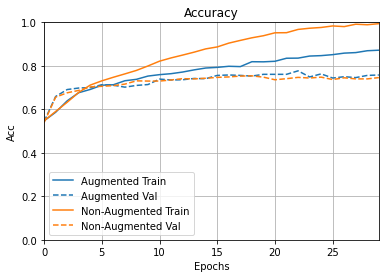

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({ "Augmented": aug_history, "Non-Augmented": history}, metric = "acc")
plt.title("Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

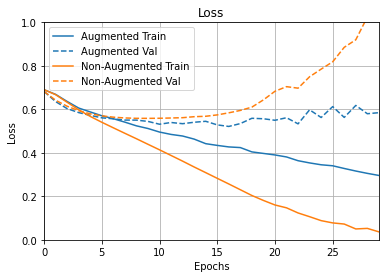

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({ "Augmented": aug_history, "Non-Augmented": history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])

As we can see, the augmented data reduced overfitting.


**exercise** Change the example above to incorporate the following types of augmentations:

- Randomly flip an image vertically (upside down)
- Randomly rotate an image
- Randomly adjust the brightness, hue, saturation, or contrast

### Task 2.2 Add dropout

In week 4, we introduced dropout as a regularisation measure. It is often applied between dense layers.

In [ ]:
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())

  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Retrain with both data augmentation and dropout.

In [ ]:
dropout_history = model.fit(
      augmented_train_batches,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_batches,
      validation_steps=100
      )

model.save('cats_and_dogs_small_augmented.h5')

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": history, "Dropout": dropout_history}, metric = "acc")
plt.title("Accuracy")
plt.ylim([0,1])

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({ "Augmented": aug_history, "Non-Augmented": history, "Dropout": dropout_history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])

As you can see that overfitting has been further reduced.

**exercise** Try different dropout rates and see how they impact on the training and validation accuracy.

## Additional resources

- TensorFlow tutorial on [image classification](https://www.tensorflow.org/tutorials/images/classification)
- TensorFlow tutorial on [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)